Figure 2A
DHX15 degradation induces splicing at cryptic splice sites. (A) Sashimi plot of reads mapping to the SNAPC1 intron and flanking exons. Data are representative of biological triplicates for each condition. 

In [ ]:
!~/pysashimi/main.py plot \
-b ../../data/pysashimi_tables/pysashimi_bam_list_sum159.txt \
-e chr14:61767253-61768735:+ \
-t 3 \
--color-factor 3 \


Figure 2B
DHX15 degradation induces splicing at cryptic splice sites. (B) Box plot quantifies number of reads mapping to cryptic splice junctions upon DMSO or dTAG13 treatment (median (line), Q1 to Q3 quartile values (boundaries of the box), and range (whiskers), n=3 biological replicates per condition).

In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def get_sj(meta_df):
    filelist = []
    for i,row in meta_df.iterrows():
        filepath = '../../data/dtag_experiments/' + \
            row['Target'] + \
            '/sj_out/'+ \
            row['Sample basename']
        filelist.append(glob.glob(filepath+'*')[0])
    return filelist


def get_ujs_from_intron(filenam,intron_id):
    test = pd.read_csv(filenam,sep='\t').dropna()
    test_filt = test.loc[[intron_id in i for i in test.intron_ids]]
    return np.sum(
        test_filt.loc[
            (test_filt['unique'] >=3) &
            (
                (test_filt['class'] == 'matching 5') |
                (test_filt['class'] == 'matching 3') | 
                (test_filt['class'] == 'intronic')
            )
        ]
    .unique)



In [3]:
meta = pd.read_csv('../../data/dtag_experiments/sum159_all_meta.tsv',sep='\t')

In [4]:
d12_meta = meta.loc[
    (meta['Clone'] == 'D12') &
    (meta['Target'] == 'DHX15') &
    (meta['Time value'] == 9) & 
    (meta['Compound'] == 'dTag13') &
    (
        (meta['Dosage value'] == 500) |
        (meta['Dosage value'] == 0)
    )
]

In [5]:
intron_gtf=pd.read_csv('../../data/annotations/hg38_ENSEMBL_92_introns.gtf',sep='\t',header=None)
intron_gtf.index = [i.split('"')[1] for i in intron_gtf.iloc[:,-1]]

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
snapc1_id = 'ENSG00000023608,ENSG00000100644,ENSG00000258964.19'
intron_gtf.loc[snapc1_id]

0                                                   14
1                                               custom
2                                               intron
3                                             61767353
4                                             61768635
5                                                    .
6                                                    +
7                                                    .
8    transcript_id "ENSG00000023608,ENSG00000100644...
Name: ENSG00000023608,ENSG00000100644,ENSG00000258964.19, dtype: object

In [7]:
d12_files = get_sj(d12_meta)

uj_counts = [get_ujs_from_intron(i,snapc1_id) for i in d12_files]

uj_df = pd.DataFrame([
    ['0nM']*3 + ['500nM']*3,
    uj_counts
]).transpose()

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


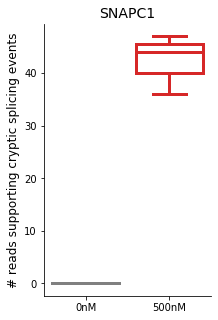

In [8]:
fig,ax=plt.subplots(figsize=(3,5))

ax = sns.boxplot(
    x=uj_df.loc[:,0],
    y=uj_df.loc[:,1],
    palette=['white','white'],
)

colors = ['grey','tab:red']

for i,box in enumerate(ax.artists):
    box.set_edgecolor(colors[i])
    box.set_linewidth(3)
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(colors[i])
        line.set_mfc(colors[i])
        line.set_mec(colors[i])
        line.set_linewidth(3)



plt.xlabel('')
plt.ylabel('# reads supporting cryptic splicing events', fontsize=12)
plt.title('SNAPC1', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


Figure 2E
(E) Degradation of DHX15 leads to use of multiple cryptic splice sites within a single intron. Bar plot of number of introns with  1-5, and 6+ cryptic splice junctions in DMSO and dTAG13 treated states (mean and SEM, n=3 biological replicates/treatment, two-tailed unpaired Student’s t-test).

In [1]:
import glob

import numpy as np
import pandas as pd

from collections import Counter

In [2]:
meta = pd.read_csv('../../data/dtag_experiments/sum159_all_meta.tsv',sep='\t')

In [3]:
def get_sj(meta_df):
    filelist = []
    for i,row in meta_df.iterrows():
        filepath = \
            '../../data/dtag_experiments/' + \
            row['Target'] + \
            '/sj_out/' + \
            row['Sample basename']
        filelist.append(glob.glob(filepath+'*tsv')[0])
    return filelist

def flatten(regular_list):
    return [item for sublist in regular_list for item in sublist]

def get_counts(filenam):
    test = pd.read_csv(filenam,sep='\t')

    test_filt = test.loc[
        (test['unique'] >= 3) & 
        ((test['class'] == 'matching 5') |
        (test['class'] == 'matching 3') |
        (test['class'] == 'intronic'))
    ]
    
    ki_df = test.loc[
        (test['unique'] >= 3) &
        (test['class'] == 'known intron')
    ]
    
    ki_all = flatten([i.split(';') for i in ki_df['intron_ids'].dropna().values])
    
    ki_no_uj = len(set(ki_all).difference(flatten([i.split(';') for i in test_filt['intron_ids'].dropna().values])))

    counter_object = Counter(
        flatten([i.split(';') for i in test_filt['intron_ids'].dropna().values])
    )

    for key in counter_object.keys():
        if counter_object[key]>10:
            counter_object[key]=10

    return pd.concat(
        [
            pd.Series(ki_no_uj,index=[0]),
            pd.DataFrame.from_dict(
                Counter([counter_object[key] for key in counter_object.keys()]),
                orient='index'
            )
        ])

In [4]:
meta_filt = meta.loc[
    (meta['Cell line'] == 'SUM159') & 
    (meta['Clone'] == 'D12') &
    (meta['Target'] == 'DHX15') &
    (meta['Time value'] == 9) &
    ((meta['Dosage value'] == 500) | (meta['Dosage value'] == 0))
]

meta_filt['filepath'] = get_sj(meta_filt)

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [5]:
count_df = pd.concat(
    [get_counts(file) for file in meta_filt['filepath'].values]
,axis=1).fillna(0)

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
count_summary = pd.concat([
    count_df.iloc[0,:],
    np.sum(count_df.iloc[1:6,:]),
    np.sum(count_df.iloc[6:,:])
],axis=1).transpose()

count_summary.index = ['0','1-5','6+']
count_summary.columns = ['veh']*3 + ['dtag']*3

In [7]:
count_summary

,veh,veh,veh,dtag,dtag,dtag
0,124300.0,124843.0,119238.0,107523.0,104699.0,104324.0
1-5,7704.0,8388.0,5207.0,29565.0,38239.0,29143.0
6+,18.0,19.0,7.0,418.0,824.0,336.0


bar plot made in prism using above values

Figure 2G
(G) Degradation of DHX15 uniquely induces all classifications of cryptic splicing. Magnitude of cryptic splicing is quantified as the total number of unique cryptic splice junctions normalized to the number of known intron splicing events. Bar plot depicts fold change in cryptic splicing magnitude compared to DMSO treatment after 9hrs of target degradation (mean +/- SEM, n=3 biological replicates/condition, two-tailed unpaired Student’s t-test).

In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Patch
from natsort import os_sorted
from scipy.stats import sem


In [18]:
def get_sj(meta_df):
    filelist = []
    for i,row in meta_df.iterrows():
        filepath = '../../data/dtag_experiments/' + \
            row['Target'] + \
            '/sj_out/' + \
            row['Sample basename'].split('_Aligned')[0]
        filelist.append(glob.glob(filepath+'*')[0])
    return filelist


In [26]:
big_meta = pd.read_csv('../../data/dtag_experiments/sum159_all_meta.tsv',sep='\t')

big_meta.index = [i.split('_Aligned')[0] for i in big_meta['Sample basename'].values]

In [19]:
def get_uj_counts(filenam):
    test = pd.read_csv(filenam, sep='\t')
    test_filt = test[test['unique'] >= 3]
    intronic = np.sum([i == 'intronic' for i in test_filt['class']])
    match_5 = np.sum([i == 'matching 5' for i in test_filt['class']])
    match_3 = np.sum([i == 'matching 3' for i in test_filt['class']])
    ki = np.sum([i == 'known intron' for i in test_filt['class']])
    
    return [ki, match_5, match_3, intronic]

def flatten(regular_list):
    return [item for sublist in regular_list for item in sublist]



In [27]:
big_filt = big_meta.loc[
    ((big_meta['Time value']>6) & (big_meta['Time value']<12))
]

big_filt['code'] = big_filt['Target'] + '_' + \
    big_filt['Dosage value'].astype('str')

big_filt['filepath'] = get_sj(big_filt)

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
uj_counts = [get_uj_counts(i) for i in big_filt['filepath'].values]

uj_df = pd.DataFrame(uj_counts)
uj_df.columns = ['known intron', 'matching 5', 'matching 3', 'intronic']

uj_df.index = [i.split('_Aligned')[0] for i in big_filt['Sample basename'].values]

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
target_list = [
    'AQR_0.0', 
    'AQR_500.0', 
    'DDX46_0.0', 
    'DDX46_200.0',   
    'DHX15_0.0', 
    'DHX15_500.0', 
    'DHX16_0.0', 
    'DHX16_400.0', 
    'DHX38_0.0',
    'DHX38_400.0', 
    'PRPF8_0.0', 
    'PRPF8_250.0', 
    'SF3B1_0.0',
    'SF3B1_200.0', 
    'U2AF2_0.0',
    'U2AF2_250.0'
]

In [30]:
uj_ki_norm = uj_df.divide(uj_df.loc[:,'known intron'],axis=0)


In [31]:
bar_vals = []
error_vals = []
for i in target_list:
    inds = big_filt[big_filt['code'] == i].index
    control_inds = big_filt[big_filt['code'] == '_'.join([i.split('_')[0]]+['0.0'])].index
    norm_df = uj_ki_norm.loc[inds,:]/np.mean(uj_ki_norm.loc[control_inds,:])    
    bar_vals.append(np.mean(norm_df.loc[inds,:]))
    error_vals.append(sem(norm_df.loc[inds,:]))
    
bar_vals = pd.DataFrame(bar_vals)
error_vals = pd.DataFrame(error_vals)

bar_vals.index = target_list
error_vals.index = target_list
error_vals.columns = uj_df.columns

In [32]:
def make_uj_plot_no_ki_ax_2(code,ax,colornam):
    xvals = [
        0, 1,  
        3, 4,  
        6, 7, 
    ]

    bools = [code in i for i in target_list]
    yvals = flatten(bar_vals.iloc[:,1:].loc[bools].transpose().values)
    errors = flatten(error_vals.iloc[:,1:].loc[bools].transpose().values)

    ax.bar(
        xvals[0::2],
        yvals[0::2],
        yerr=errors[0::2],
        color='grey',
    )
    ax.bar(
        xvals[1::2],
        yvals[1::2],
        yerr=errors[1::2],
        color=colornam,
    )

    trt_vals = ['{:g}'.format(float(i.split('_')[1])) + ' nM' for i in np.array(target_list)[bools]]
    
    legend_elements = [
        Patch(
            facecolor='grey',
            label=trt_vals[0]
        ),
        Patch(
            facecolor=colornam,
            label=trt_vals[1] 
        ),
    ]

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    ax.legend(handles = legend_elements)

    xticks = [0.5, 3.5, 6.5]
    xtick_labs = ['cryptic 3ss', 'cryptic 5ss', 'intronic']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labs,
                       fontsize=12,
                       rotation=40,
                       ha='right', 
                       rotation_mode='anchor')

    ax.set_title(code, fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

(0, 10.5)

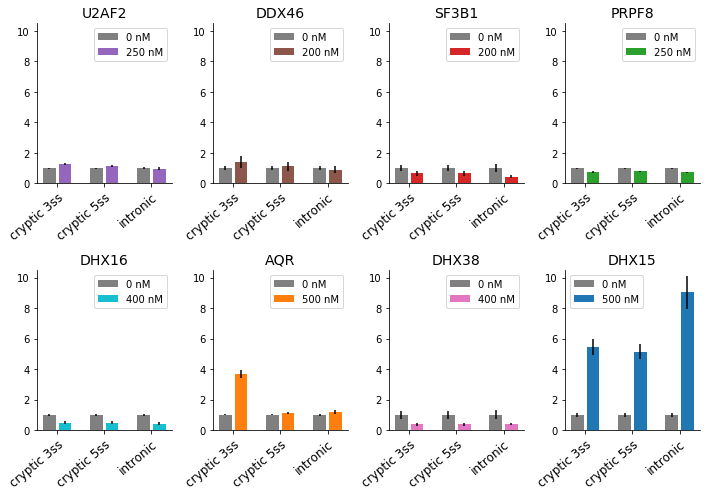

In [33]:
ylim = 10.5

fig,((ax1,ax2,ax3,ax4),(ax6,ax7,ax8,ax9)) = plt.subplots(2,4,figsize=(10,7))

make_uj_plot_no_ki_ax_2('DHX15',ax9,'tab:blue')
make_uj_plot_no_ki_ax_2('AQR',ax7,'tab:orange')
make_uj_plot_no_ki_ax_2('PRPF8',ax4,'tab:green')
make_uj_plot_no_ki_ax_2('U2AF2',ax1,'tab:purple')
make_uj_plot_no_ki_ax_2('SF3B1',ax3,'tab:red')
make_uj_plot_no_ki_ax_2('DDX46',ax2,'tab:brown')
make_uj_plot_no_ki_ax_2('DHX16',ax6,'tab:cyan')
make_uj_plot_no_ki_ax_2('DHX38',ax8,'tab:pink')

plt.tight_layout(w_pad=3)

ax1.set_ylim([0,ylim])
ax2.set_ylim([0,ylim])
ax3.set_ylim([0,ylim])
ax4.set_ylim([0,ylim])
ax6.set_ylim([0,ylim])
ax7.set_ylim([0,ylim])
ax8.set_ylim([0,ylim])
ax9.set_ylim([0,ylim])


Figure 2H
(H) DHX15 degradation similarly induces cryptic splicing in an additional TNBC cell line, MDA-MB-231-LM2. Magnitude of cryptic splicing is quantified as the number of unique cryptic splice junctions normalized to the number of known intron splicing events. Bar plot depicts fold change in cryptic splicing magnitude compared to DMSO treatment after 9hrs of target degradation (mean +/- SEM, n=3 biological replicates/condition, two-tailed unpaired Student’s t-test).

In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Patch
from natsort import os_sorted
from scipy.stats import sem

In [2]:
def get_sj(meta_df):
    filelist = []
    for i,row in meta_df.iterrows():
        filepath = '../../data/dtag_experiments/' + \
            row['Target'] + \
            '/sj_out/'+ \
            row['Sample basename']
        filelist.append(glob.glob(filepath+'*')[0])
    return filelist


In [3]:
meta_max = pd.read_csv('../../data/dtag_experiments/lm2_meta_9.txt',sep='\t')
meta_max['filepath'] = get_sj(meta_max)


meta_max.index = [i.split('_Aligned')[0] for i in meta_max['Sample basename'].values]

meta_max['Dosage value'] = meta_max['Dosage value'].astype('str')
meta_max['Time value'] = meta_max['Time value'].astype('str')

meta_max['code'] = meta_max['Target'] + '_' + \
    meta_max['Time value'] + '_' + \
    meta_max['Dosage value']

In [4]:
def get_uj_counts(filenam):
    test = pd.read_csv(filenam, sep='\t')
    test_filt = test[test['unique'] >= 3]
    intronic = np.sum([i == 'intronic' for i in test_filt['class']])
    match_5 = np.sum([i == 'matching 5' for i in test_filt['class']])
    match_3 = np.sum([i == 'matching 3' for i in test_filt['class']])
    ki = np.sum([i == 'known intron' for i in test_filt['class']])
    
    return [ki, match_5, match_3, intronic]

def flatten(regular_list):
    return [item for sublist in regular_list for item in sublist]


In [5]:
uj_counts = [get_uj_counts(i) for i in meta_max['filepath'].values]


/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
uj_df = pd.DataFrame(uj_counts)
uj_df.columns = ['known intron', 'matching 5', 'matching 3', 'intronic']

uj_df.index = [i.split('_Aligned')[0] for i in meta_max['Sample basename'].values]

uj_ki_norm = uj_df.divide(uj_df.loc[:,'known intron'],axis=0)


In [7]:
target_list = os_sorted(list(set(meta_max['code'])))

In [8]:
bar_vals = []
error_vals = []
for i in target_list:
    inds = meta_max[meta_max['code'] == i].index
    control_inds = meta_max[meta_max['code'] == '_'.join(i.split('_')[0:2]+['0.0'])].index
    norm_df = uj_ki_norm.loc[inds,:]/np.mean(uj_ki_norm.loc[control_inds,:])    
    bar_vals.append(np.mean(norm_df.loc[inds,:]))
    error_vals.append(sem(norm_df.loc[inds,:]))
    
bar_vals = pd.DataFrame(bar_vals)
error_vals = pd.DataFrame(error_vals)

bar_vals.index = target_list
error_vals.index = target_list
error_vals.columns = uj_df.columns

In [9]:
def make_uj_plot_no_ki_ax(code,ax,colornam):
    xvals = [
        0, 1,  
        3, 4,  
        6, 7, 
    ]

    bools = [code in i for i in target_list]
    yvals = flatten(bar_vals.iloc[:,1:].loc[bools].transpose().values)
    errors = flatten(error_vals.iloc[:,1:].loc[bools].transpose().values)

    ax.bar(
        xvals[0::2],
        yvals[0::2],
        yerr=errors[0::2],
        color='grey',
    )


    ax.bar(
        xvals[1::2],
        yvals[1::2],
        yerr=errors[1::2],
        color=colornam,
        alpha=1
    )

    trt_vals = ['{:g}'.format(float(i.split('_')[2])) + ' nM' for i in np.array(target_list)[bools]]
    
    legend_elements = [
        Patch(
            facecolor='grey',
            label=trt_vals[0]
        ),
        Patch(
            facecolor=colornam,
            label=trt_vals[1] 
        ),
    ]

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    ax.legend(handles = legend_elements,loc='upper center')

    xticks = [0.5, 3.5, 6.5]
    xtick_labs = ['cryptic 3ss', 'cryptic 5ss', 'intronic']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labs,
                       fontsize=12,
                       rotation=40,
                       ha='right', 
                       rotation_mode='anchor')

    ax.set_title(code, fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

Text(9.625, 0.5, 'Relative UJ expression')

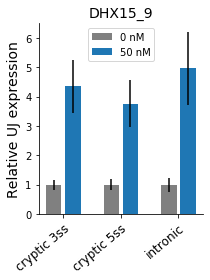

In [10]:
ylim = 6.5

fig,ax1 = plt.subplots(figsize=(3,4))

make_uj_plot_no_ki_ax('DHX15_9',ax1,'tab:blue')


plt.tight_layout(w_pad=3)

ax1.set_ylim([0,ylim])

ax1.set_ylabel('Relative UJ expression',fontsize=14)


Figure 2I
(I) Similar cryptic splice junctions are utilized in both SUM159 and LM2 cells upon DHX15 degradation. Sashimi plot of reads mapping to the SNAPC1 intron and flanking exons. Data are representative of biological triplicates for each condition. Splice junctions with >= 3 reads are shown.

In [ ]:
%%capture

!~/pysashimi/main.py plot \
-b ../../data/pysashimi_tables/pysashimi_bam_list_lm2.txt \
-e chr14:61767253-61768735:+ \
-t 3 \
--color-factor 3 \


Figure 2L
Cryptic splice junction usage is increased in both SUM159 and LM2 cells upon DHX15 degradation. (L) Sashimi plot of reads mapping to the cryptic splice junction and flanking exons. Data are representative of biological triplicates for each condition.

In [ ]:
%%capture

!~/pysashimi/main.py plot \
-b ../../data/pysashimi_tables/pysashimi_bam_list_sum159_lm2.txt \
-e chr15:69414350-69416093:+ \
-t 3 \
--color-factor 3 \
